In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
path = ''
sys.path.append(path)
import utils
import settings
import pickle
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [4]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [5]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

# Hyper params

In [6]:
train_delta_t = 0
max_depth = 4
eval_metric = 'rmse'
n_estimators = 10000
scaler_name = 'MinMaxScaler'
scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()
random_state = 42
submission_path = 'sub_4_inputs/'
test_set_param = 'basic'

In [7]:
path = path
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
test = pd.read_csv(path+"test.csv")
sample_submission = pd.read_csv(path+"sample_submission.csv")

In [8]:
X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.get_reshaped_files3()

In [9]:
def clean_reshaped_data(df: pd.DataFrame):
    columns_to_drop = ['date_forecast_1', 'date_forecast_2', 'date_forecast_0']
    df_cleaned = df.copy()
    df_cleaned.rename(columns={'date_forecast_3': 'date_forecast'}, inplace=True)
    df_cleaned = df_cleaned.drop(columns=columns_to_drop)
    df_cleaned['date_forecast'] = df_cleaned['date_forecast'] # + pd.Timedelta(hours=1)
    return df_cleaned

In [10]:
X_train_estimated_a = clean_reshaped_data(X_train_estimated_a)
X_train_estimated_b = clean_reshaped_data(X_train_estimated_b)
X_train_estimated_c = clean_reshaped_data(X_train_estimated_c)
X_train_observed_a = clean_reshaped_data(X_train_observed_a)
X_train_observed_b = clean_reshaped_data(X_train_observed_b)
X_train_observed_c = clean_reshaped_data(X_train_observed_c)
X_test_estimated_a = clean_reshaped_data(X_test_estimated_a)
X_test_estimated_b = clean_reshaped_data(X_test_estimated_b)
X_test_estimated_c = clean_reshaped_data(X_test_estimated_c)

In [11]:
X_train_estimated_b['date_forecast'] = X_train_estimated_b['date_forecast']+ pd.Timedelta(minutes=15)

# B and C clean up

In [12]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

In [13]:
def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [14]:
delta = { 'hours': 12 * 5}
train_a = delete_date_range_from_df(train_a, filter_dates_when_constants(train_a, delta=delta))
train_b = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
train_c = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))

In [15]:
delta_title = str(train_delta_t)
delta_h = pd.Timedelta(minutes=train_delta_t)
train_a['date_forecast'] = train_a['time'] - delta_h
train_b['date_forecast'] = train_b['time'] - delta_h
train_c['date_forecast'] = train_c['time'] - delta_h

# Réorganisation des df :

In [16]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a,X_train_estimated_a])
X_total_b = pd.concat([X_train_observed_b,X_train_estimated_b])
X_total_c = pd.concat([X_train_observed_c,X_train_estimated_c])

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

In [18]:
# train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# test.rename(columns={'time': 'date_forecast'}, inplace=True)
train_a, train_b, train_c = train_a.drop(columns='time'), train_b.drop(columns='time'), train_c.drop(columns='time')
train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [19]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

In [20]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [21]:
def gestion_nan(df):
  df_copy = df.copy()
  snow_density = [ f'snow_density:kgm3_{k}' for k in range(4) ]
  #delete of the snow density column
  for k in range(4): 
    df_copy = df_copy.drop(snow_density[k],axis=1)
  # Approximation of the other two columns
    df_copy[f'ceiling_height_agl:m_{k}'] = df_copy[f'ceiling_height_agl:m_{k}'].interpolate(method='linear', limit_direction='both')
    df_copy[f'cloud_base_agl:m_{k}'] = df_copy[f'cloud_base_agl:m_{k}'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [22]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [23]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

30904
4577
0.12899861897917195


In [24]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [25]:
split_date_a = X_train_estimated_a['date_forecast'].quantile(0.25)
split_date_b = X_train_estimated_b['date_forecast'].quantile(0.25)
split_date_c = X_train_estimated_c['date_forecast'].quantile(0.25)

In [26]:
split_date_a = pd.to_datetime("2021-04-15")
split_date2_a = pd.to_datetime("2021-08-15")

split_date_b = pd.to_datetime("2019-04-15")
split_date2_b = pd.to_datetime("2019-08-15")

split_date_c = pd.to_datetime("2021-04-15")
split_date2_c = pd.to_datetime("2021-08-15")

In [27]:
start_2019 = pd.to_datetime("2019-04-21")
end_2019 = pd.to_datetime("2019-07-22")

start_2020 = pd.to_datetime("2020-04-21")
end_2020 = pd.to_datetime("2020-07-22")

start_2021 = pd.to_datetime("2021-04-21")
end_2021 = pd.to_datetime("2021-07-22")

start_2022 = pd.to_datetime("2022-04-21")
end_2022 = pd.to_datetime("2022-07-22")

In [28]:
def create_mask_for_split_training_and_testing(df, start_estimated, time_column = 'date_forecast'):
    mask_2019 = ((df[time_column] >= start_2019) & (df[time_column] < end_2019))
    mask_2020 = ((df[time_column] >= start_2020) & (df[time_column] < end_2020))
    mask_2021 = ((df[time_column] >= start_2021) & (df[time_column] < end_2021))
    mask_2022 = ((df[time_column] >= start_2022) & (df[time_column] < end_2022))
    mask_estimated = (df[time_column] >= start_estimated)
    return mask_2019, mask_2020, mask_2021, mask_2022,mask_estimated

In [29]:
def split_training_testing_set_on_test_set_dates():
    quantile = .25
    pv_train_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] <= X_train_estimated_a['date_forecast'].quantile(quantile)].copy()
    pv_test_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] > X_train_estimated_a['date_forecast'].quantile(quantile)].copy()

    pv_train_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] <= X_train_estimated_b['date_forecast'].quantile(quantile)].copy()
    pv_test_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] > X_train_estimated_b['date_forecast'].quantile(quantile)].copy()

    pv_train_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] <= X_train_estimated_c['date_forecast'].quantile(quantile)].copy()
    pv_test_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] > X_train_estimated_c['date_forecast'].quantile(quantile)].copy() 
    return pv_train_a, pv_test_a, pv_train_b, pv_test_b, pv_train_c, pv_test_c

In [30]:
def split_training_testing_set(df, start_estimated, random_state=42, test_size = .1, time_column = 'date_forecast'):
    df_to_split = df.copy()
    mask_2019, mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)

    df_summers = df_to_split[mask_2019 | mask_2020 | mask_2021 | mask_2022]
    df_estimated = df_to_split[mask_estimated]
    print(len(df_estimated))
    df_not_summer = df_to_split[~(mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated)]

    # test_size_summer = test_size * (len(df_summers) + len(df_not_summer) + len(df_estimated)) / (len(df_summers) + len(df_estimated))
    # test_size_estimated = test_size * (len(df_summers) + len(df_not_summer) + len(df_estimated)) / (len(df_summers) + len(df_estimated))

    test_size_estimated = 0.8
    test_size_summer = ( test_size * (len(df_summers) + len(df_not_summer) + len(df_estimated)) - test_size_estimated * len(df_estimated) ) / len(df_summers)
    # test_size_summer = ( test_size * (len(df_summers) + len(df_not_summer) + len(df_estimated)) - test_size_estimated * len(df_estimated) ) / len(df_summers)
    # test_size_estimated = 1 - test_size_summer
    # train_data_summer, pv_test_not_ordered = train_test_split(df_summers, test_size=test_size, random_state=random_state)

    unique_dates_summer = df_summers[time_column].dt.date.unique()
    unique_dates_estimated = df_summers[time_column].dt.date.unique()

    train_dates_summer, test_dates_summer = train_test_split(unique_dates_summer, test_size=test_size_summer, random_state=random_state)
    train_dates_estimated, test_dates_estimated = train_test_split(unique_dates_estimated, test_size=test_size_estimated, random_state=random_state)

    train_data_summer = df_summers[df_summers[time_column].dt.date.isin(train_dates_summer)]
    train_data_estimated = df_estimated[df_estimated[time_column].dt.date.isin(train_dates_estimated)]

    pv_test_summer_not_ordered = df_summers[df_summers[time_column].dt.date.isin(test_dates_summer)]
    pv_test_estimated_not_ordered = df_estimated[df_estimated[time_column].dt.date.isin(test_dates_estimated)]

    pv_test_not_ordered = pd.concat([pv_test_summer_not_ordered, pv_test_estimated_not_ordered])
    pv_train_not_ordered = pd.concat([train_data_summer, train_data_estimated, df_not_summer])

    pv_train = pv_train_not_ordered.sort_values(by=time_column)
    pv_test = pv_test_not_ordered.sort_values(by=time_column)
    return pv_train, pv_test

In [31]:
def split_training_testing_set(df, start_estimated, random_state=42, text_size = .1, time_column = 'date_forecast'):
    df_to_split = df.copy()
    mask_2019, mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)
    df_summers = df_to_split[mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated]
    df_not_summer = df_to_split[~(mask_2019 | mask_2020 | mask_2021 | mask_2022 | mask_estimated)]
    test_size = text_size * (len(df_summers) + len(df_not_summer)) / len(df_summers)
    train_data_summer, pv_test_not_ordered = train_test_split(df_summers, test_size=test_size, random_state=random_state)

    pv_train_not_ordered = pd.concat([train_data_summer, df_not_summer])
    pv_train = pv_train_not_ordered.sort_values(by='date_forecast')
    pv_test = pv_test_not_ordered.sort_values(by='date_forecast')
    return pv_train, pv_test

In [32]:
# create_mask_for_split_training_and_testing(df, start_estimated, time_column = 'date_forecast')
df_to_split = X_total_b_y_nan
start_estimated = X_train_estimated_b["date_forecast"].mean()
mask_2019, mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)

In [33]:
pv_train_a, pv_test_a = split_training_testing_set(X_total_a_y_nan, X_train_estimated_a["date_forecast"].mean(), random_state=random_state)
pv_train_b, pv_test_b = split_training_testing_set(X_total_b_y_nan, X_train_estimated_b["date_forecast"].mean(), random_state=random_state)
pv_train_c, pv_test_c = split_training_testing_set(X_total_c_y_nan, X_train_estimated_c["date_forecast"].mean(), random_state=random_state)

In [34]:
if test_set_param=='basic': pv_train_a, pv_test_a, pv_train_b, pv_test_b, pv_train_c, pv_test_c = split_training_testing_set_on_test_set_dates()

In [35]:

print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100, '%')
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100, '%')
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100, '%')

train_a : (30750, 178)
test_a : (3294, 178)
Rapport test/total : 9.700000000000001 %
train_b : (24468, 178)
test_b : (2693, 178)
Rapport test/total : 9.9 %
train_c : (19675, 178)
test_c : (2026, 178)
Rapport test/total : 9.3 %


## Changement type de la date_forecast

In [36]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [37]:
#function to apply XGBoost model
def create_features(df, label):

    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(["date_calc","date_forecast"],axis=1) if "date_calc" in df.columns else df.drop(["date_forecast"],axis=1) # date de calcul des estimated inutil pour l'instant
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [38]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Normalisation

In [39]:
def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None,fit=True):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      # scaler = Normalizer()
      # scaler = RobustScaler()
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : 
      if fit:
        normalized_data = scaler.fit_transform(df)
      else: 
        normalized_data = scaler.transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [40]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True, scaler=scaler_a)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True, scaler=scaler_b)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True, scaler=scaler_c)

In [41]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a, fit=False)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b, fit=False)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c, fit=False)

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base (Nahel)

In [42]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

In [43]:
import pandas as pd
import tensorflow as tf

import autokeras as ak

Using TensorFlow backend


In [ ]:
tf.keras.optimizers.legacy.Adam

In [44]:
predict_from = 1
predict_until = 10
lookback = 3
clf_a = ak.TimeseriesForecaster(
    lookback=lookback,
    predict_from=predict_from,
    predict_until=predict_until,
    max_trials=1,
    objective="val_loss",
)
# Train the TimeSeriesForecaster with train data
clf_a.fit(
    x=X_train_a_norm,
    y=y_train_a,
    validation_data=(X_test_a_norm, y_test_a),
    batch_size=32,
    epochs=10,
)


Trial 1 Complete [00h 03m 14s]
val_loss: 980343.3125

Best val_loss So Far: 980343.3125
Total elapsed time: 00h 03m 14s


Epoch 1/10
961/961 [==============================] - 14s 13ms/step - loss: 1673115.7500 - mean_squared_error: 1673115.7500 - val_loss: 1012266.7500 - val_mean_squared_error: 1012266.7500
Epoch 2/10
961/961 [==============================] - 12s 13ms/step - loss: 1514393.8750 - mean_squared_error: 1514393.8750 - val_loss: 984679.6875 - val_mean_squared_error: 984679.6875
Epoch 3/10
961/961 [==============================] - 13s 13ms/step - loss: 1443173.1250 - mean_squared_error: 1443173.1250 - val_loss: 992067.4375 - val_mean_squared_error: 992067.4375
Epoch 4/10
961/961 [==============================] - 12s 13ms/step - loss: 1415028.3750 - mean_squared_error: 1415028.3750 - val_loss: 1007795.6875 - val_mean_squared_error: 1007795.6875
Epoch 5/10
961/961 [==============================] - 12s 12ms/step - loss: 1459849.1250 - mean_squared_error: 1459849.1250 - val_loss: 1000527.0000 - val_mean_squared_error: 1000527.0000
Epoch 6/10
961/961 [==============================] - 11s 11ms/s

INFO:tensorflow:Assets written to: ./time_series_forecaster/best_model/assets


ValueError: The prediction data requires the original training data to make predictions on subsequent data points

In [45]:

# Predict with the best model(includes original training data).
predictions = clf_a.predict(X_train_a_norm)
print(predictions.shape)
# Evaluate the best model with testing data.
print(clf_a.evaluate(X_test_a_norm, y_test_a))

961/961 [==============================] - 5s 5ms/step
(0, 1)


103/103 [==============================] - 1s 3ms/step - loss: 984690.0625 - mean_squared_error: 984690.0625
[984690.0625, 984690.0625]


In [46]:

print(clf_a.evaluate(X_test_a_norm, y_test_a))

103/103 [==============================] - 1s 3ms/step - loss: 984690.0625 - mean_squared_error: 984690.0625
[984690.0625, 984690.0625]


In [48]:
predictions

array([], shape=(0, 1), dtype=float32)

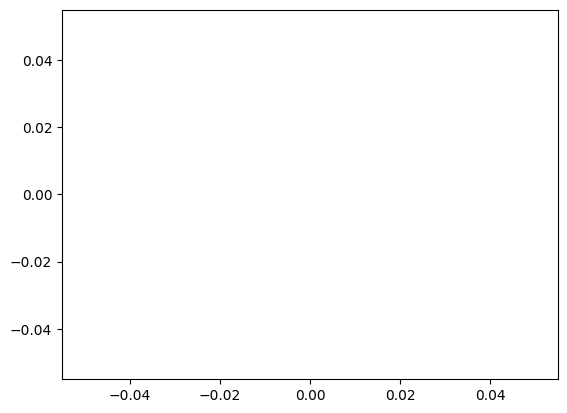

In [47]:
plt.plot(predictions)

In [ ]:
# Créez un modèle XGBoost
reg_a = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )

# Entraînez le modèle et suivez l'évolution des erreurs
reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

reg_b = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )
reg_b.fit(X_train_b_norm, y_train_b,
          eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
          early_stopping_rounds=50,
          verbose=True)

reg_c = xgb.XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth,
                        eval_metric = eval_metric,
                        )
reg_c.fit(X_train_c_norm, y_train_c,
          eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
          early_stopping_rounds=50,
          verbose=True)

In [ ]:
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_a.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_b.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_b = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_c.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

min_error_c = min(test_errors)
# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

In [ ]:
min_error_a, min_error_b, min_error_c

In [ ]:
plot_importance(reg_a, height=.9)
plt.gcf().set_size_inches(14, 8 * 4)
plot_importance(reg_b, height=0.9)
plt.gcf().set_size_inches(14, 8 * 4)
plot_importance(reg_c, height=0.9)
plt.gcf().set_size_inches(14, 8 * 4)

In [ ]:
pv_test_a['pv_measurement_prediction'] = reg_a.predict(X_test_a_norm)
pv_all_a = pd.concat([pv_test_a, pv_train_a], sort=False)

pv_test_b['pv_measurement_prediction'] = reg_b.predict(X_test_b_norm)
pv_all_b = pd.concat([pv_test_b, pv_train_b], sort=False)

pv_test_c['pv_measurement_prediction'] = reg_c.predict(X_test_c_norm)
pv_all_c = pd.concat([pv_test_c, pv_train_c], sort=False)

In [ ]:
pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_c[pv_test_c['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.

In [ ]:
mae_a = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_a['pv_measurement_prediction']))
mae_b = np.mean(np.abs(pv_all_b['pv_measurement'] - pv_all_b['pv_measurement_prediction']))
mae_c = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_c['pv_measurement_prediction']))

df_mae = pd.concat([pv_all_a, pv_all_b, pv_all_a])
mae = np.mean(np.abs(df_mae['pv_measurement'] - df_mae['pv_measurement_prediction']))
print("MAE a:", mae_a, "MAE b:", mae_b, "MAE c:", mae_c)
print("MAE on test set:", mae)

In [ ]:
graph = pv_all_a[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')

In [ ]:
np_pv_c = np.array(pv_all_c['pv_measurement'])
plt.plot(np_pv_c)

# Export sur Kaggle

In [ ]:
test = pd.read_csv(path+"test.csv")
test_copy = test.copy()
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [ ]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_test_estimated_a, test, on='date_forecast', how='inner')
merged_df_a = merged_df_pre_a[merged_df_pre_a["location"]=="A"]
merged_df_pre_b = pd.merge(X_test_estimated_b, test, on='date_forecast', how='inner')
merged_df_b = merged_df_pre_b[merged_df_pre_b["location"]=="B"]
merged_df_pre_c = pd.merge(X_test_estimated_c, test, on='date_forecast', how='inner')
merged_df_c = merged_df_pre_c[merged_df_pre_c["location"]=="C"]

In [ ]:
def preprocessing_test(df,scaler):
  X_test = df.drop(["id","location","prediction"],axis=1)
  X_test = create_features(X_test, None)
  #X_test[('date_forecast')] = X_test[('date_forecast')].values.astype("float64")
  X_test = gestion_nan(X_test)
  X_test = sklearn_z_score_normalize_dataframe(X_test,return_scaler=False,scaler=scaler, fit=False)
  return X_test

In [ ]:
X_test_a_test = preprocessing_test(merged_df_a,scaler_a)
X_test_b_test = preprocessing_test(merged_df_b,scaler_b)
X_test_c_test = preprocessing_test(merged_df_c,scaler_c)

In [ ]:
result_A = reg_a.predict(X_test_a_test)
result_B = reg_b.predict(X_test_b_test)
result_C = reg_c.predict(X_test_c_test)

In [ ]:
len(result_A) + len(result_B) + len(result_C)

In [ ]:
plt.plot(result_A)

In [ ]:
# nom_fichier = 'XGBoost_Valentin_V2'
# repertoire = path
# result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
# test_copy['prediction'] = result
# sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
# sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

Prochaines amélioration

- mettre un minimum *Done*
- suppression des zones continues en B et C *To DO*
- prise en compte de la date (jour/mois/heure) *Done* peut être ajusté ?
- prendre le meilleur model : celui avec le meilleur score sur le deuxième testset (A : 2,8% B : 5,5%  C: 11,5%) (score eval prévu : 166) --> déjà pris en copmte dans la fonction ...


Perf V1:

A : Test 2 : 446 / 459

B : Test 2 : 101 / 107

C : Test 2 : 68 / 78

Perf V2:

A : Test 1 : 243 | Test 2 : 438 / 455

B : Test 1 : 35 | Test 2 : 106 / 110

C : Test 1 : 26 | Test 2 : 65 / 71

# Post traitement

Ici, on va faire en sorte de n'avoir que des valeurs positives (cela ne représente qu'une légère amélioration

In [ ]:
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [ ]:
len(result_A), len(result_B), len(result_C)

In [ ]:
negative_values = result[result < 0]
sum_of_negatives = np.sum(negative_values**2)/len(result)
np.sqrt(sum_of_negatives)

In [ ]:
negative_mask = result < 5
result[negative_mask] = 0

In [ ]:
nom_fichier = f'AUTOML_separated_loc_4_inputs_n_estimators_{n_estimators}_delta_{delta_title}_min_{scaler_name}_{eval_metric}_max_depth_{max_depth}_mae_{int(mae)}_rmse_{int(min_error_a)}_{int(min_error_b)}_{int(min_error_c)}_test_set_gen_{test_set_param}_{random_state}_by_day'
repertoire = submission_path
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

In [ ]:
result2 = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [ ]:
negative_mask2 = result2 < 10
result2[negative_mask2] = 0